### Phoenix Biodiversity 
***
Author: William Mullins

Date: 12-06-2025

### Subdivision Preperation
***
Import necessary libraries


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import geopandas as gpd
import rioxarray as rioxr
from shapely import box

import pystac_client
import planetary_computer
from IPython.display import Image, HTML, display

Import census subdivision shapefile

In [80]:
url = "https://www2.census.gov/geo/tiger/TIGER2024/COUSUB/tl_2024_04_cousub.zip"
subdivisions = gpd.read_file(url)
subdivisions_phoenix = subdivisions[subdivisions.NAME.str.contains("Phoenix")]
subdivisions.head()

,STATEFP,COUNTYFP,COUSUBFP,COUSUBNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,04,005,91198,01934931,0400591198,0600000US0400591198,Flagstaff,Flagstaff CCD,22,Z5,G4040,S,12231962349,44576380,+35.1066122,-111.3662507,"POLYGON ((-112.13370 35.85596, -112.13368 35.8..."
1,04,005,91838,01934953,0400591838,0600000US0400591838,Kaibab Plateau,Kaibab Plateau CCD,22,Z5,G4040,S,7228864156,29327221,+36.5991097,-112.1368033,"POLYGON ((-112.66039 36.53941, -112.66033 36.5..."
2,04,005,91683,01934950,0400591683,0600000US0400591683,Hualapai,Hualapai CCD,22,Z5,G4040,S,2342313339,3772690,+35.9271665,-113.1170408,"POLYGON ((-113.35416 36.04097, -113.35416 36.0..."
3,04,023,92295,01934961,0402392295,0600000US0402392295,Nogales,Nogales CCD,22,Z5,G4040,S,1762339489,2382710,+31.4956020,-111.0171332,"POLYGON ((-111.36692 31.52136, -111.36316 31.5..."
4,04,023,92550,01934966,0402392550,0600000US0402392550,Patagonia,Patagonia CCD,22,Z5,G4040,S,1439560139,685527,+31.5664619,-110.6410279,"POLYGON ((-110.96273 31.68695, -110.96251 31.6..."


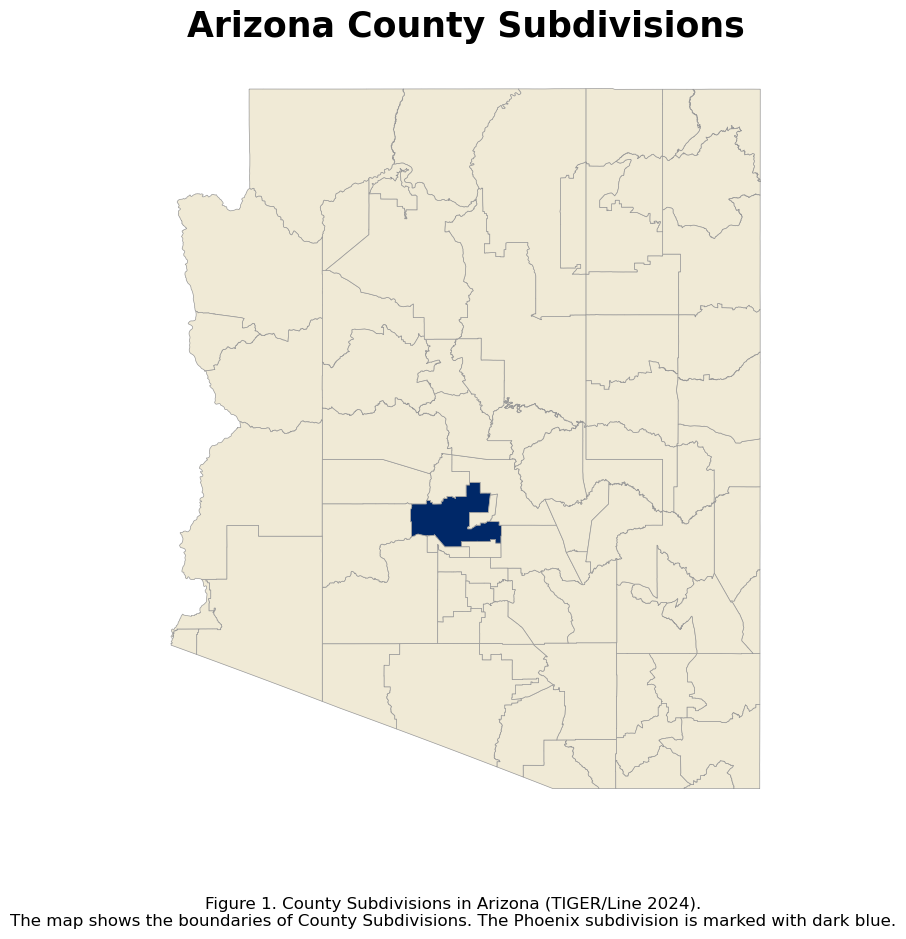

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Create Color Scheme Based on County Name
colors = ['#002868' 
          if 'Phoenix' in name
          else '#F0EAD6' 
          for name in subdivisions["NAME"].astype(str)]

# Plot all of the subdivisons in Arizona
subdivisions.plot(
    ax=ax,
    color = colors,
    edgecolor="0.6",
    linewidth=0.5
)

# Add title and caption for better context
ax.set_title('Arizona County Subdivisions', fontsize=25, weight='bold', pad=12)
plt.figtext(0.5, 0.01, "Figure 1. County Subdivisions in Arizona (TIGER/Line 2024).\nThe map shows the boundaries of County Subdivisions. The Phoenix subdivision is marked with dark blue.", wrap=True, horizontalalignment='center', fontsize=12)

ax.axis('off')
plt.show()

### Prepare Biodiversity Intactness Data
***

In order to conduct this analysis we need to import the [Impact Observatory's Biodiversity Intactness](https://planetarycomputer.microsoft.com/dataset/io-biodiversity#overview) data from 2017 to 2020. In order to access it we must first connect to the Microsoft Planetary Computer data catalogue and then search for the desired data and area.

In [82]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# Specify desired area
bbox_phoenix = [-112.826843, 32.974108, -111.184387, 33.863574]

# Search catalog 
search = catalog.search(collections=["io-biodiversity"], 
                        bbox=bbox_phoenix)

# Retrieve items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 4 Items


The data then needs to be searched for areas within the `bbox_pheonix` declared above.

We can then specify which years we want to access, and view the pre-rendered image within those years

In [83]:
bii_2017, bii_2020 = (items[3], items[0])

# View plots side by side
display(HTML(f"""
<table>
    <tr>
        <th style = "text-align: center;">2017</th>
        <th style = "text-align: center;">2020</th>
    </tr>
    <tr>
        <td><img src='{bii_2017.assets['rendered_preview'].href}' style="width: 300px;"/></td>
        <td><img src='{bii_2020.assets['rendered_preview'].href}' style="width: 300px;"/></td>
    </tr>
</table>
"""))

2017,2020
,


The raster data can then be opened for both of the years

In [84]:
raster_2017, raster_2020 = (rioxr.open_rasterio(bii_2017.assets['data'].href),
                            rioxr.open_rasterio(bii_2020.assets['data'].href))
raster_2017

<xarray.DataArray (band: 1, y: 7992, x: 7992)> Size: 255MB
[63872064 values with dtype=float32]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [85]:
# Remove length one dimension (band)
raster_2017, raster_2020 = (raster_2017.squeeze().drop_vars('band'),
                            raster_2020.squeeze().drop_vars('band'))

print("Sizes of dimensions:", 
      "\n    2017 Raster:", dict(raster_2017.sizes), 
      "\n    2020 Raster:", dict(raster_2020.sizes))

Sizes of dimensions: 
    2017 Raster: {'y': 7992, 'x': 7992} 
    2020 Raster: {'y': 7992, 'x': 7992}


In [109]:
# Match CRSs and verify update
subdivisions_phoenix_match = subdivisions_phoenix.to_crs(raster_2017.rio.crs)
assert subdivisions_phoenix_match.crs == raster_2017.rio.crs

raster_2017_step1, raster_2020_step1 = (raster_2017.rio.clip_box(*subdivisions_phoenix_match.total_bounds),
                                        raster_2020.rio.clip_box(*subdivisions_phoenix_match.total_bounds))

raster_2017_clipped, raster_2020_clipped = (raster_2017_step1.rio.clip(subdivisions_phoenix_match.geometry),
                                        raster_2020_step1.rio.clip(subdivisions_phoenix_match.geometry))

We can now find the percent of area in Phoenix with a BII >= 0.75 by dividing the number of pixels which meet that condition by the total number of pixels.

In [110]:
percent_2017 = ((raster_2017_clipped >= 0.75).sum().item() / raster_2017_clipped.count().item()) * 100 
percent_2020 = ((raster_2020_clipped >= 0.75).sum().item() / raster_2020_clipped.count().item()) * 100 

print("Percent of Area With BII >= 0.75",
      "\n    2017:", percent_2017,
      "\n    2020:", percent_2020)

Percent of Area With BII >= 0.75 
    2017: 7.125184529081784 
    2020: 6.491290227339828


### Plot of BII Biodiversity Intactness in 2020
***

The last thing required for this plot t to make a mask showing places which had a BII of over 0.75 in 2017 which no longer did in 2020.

In [122]:
# Create Mask
lost_area = (raster_2017_clipped >= 0.75) & (raster_2020_clipped < 0.75)

# Remove false values
lost_area = lost_area.where(lost_area)

In [135]:
Plot of Data:

Text(0.5, 0.01, 'Figure 2. Biodiversity Intactness in Pheonix in 2020.\n Red area indicates places where the index has fallen below 0.75 since 2017')

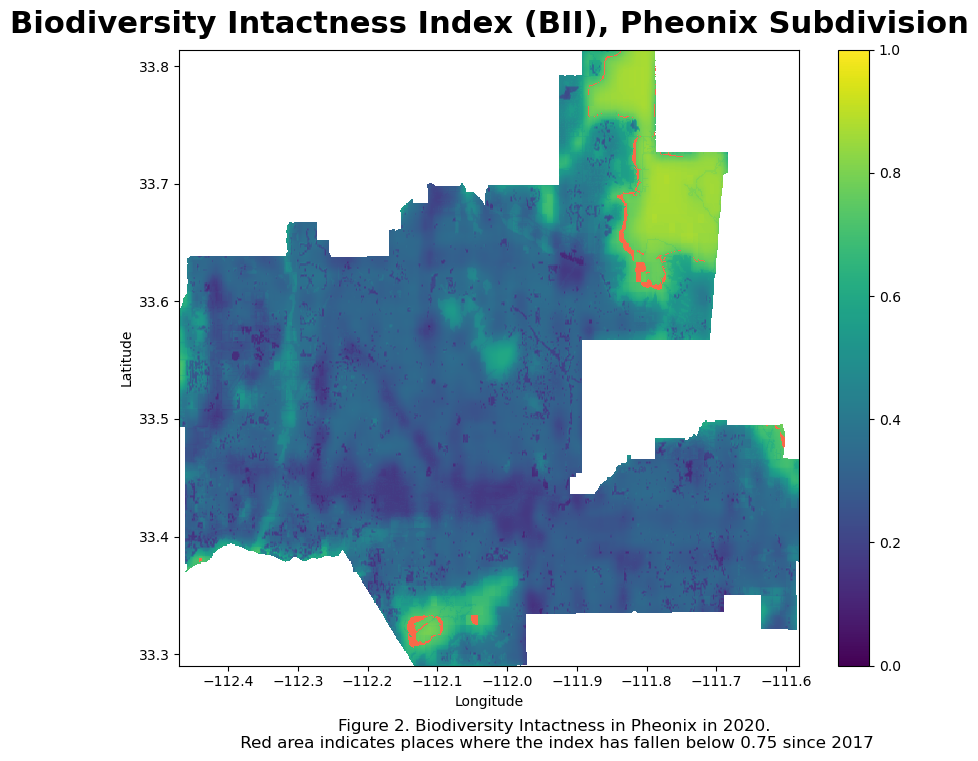

In [152]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Plot 2020 Data
raster_2020_clipped.plot.imshow(
    ax=ax,
    vmin=0,
    vmax=1,
    add_colorbar=True
)

# Overlay Area Lost
lost_area.plot.imshow(
    ax=ax,
    cmap='Reds',
    add_colorbar=False,
    vmin=0.5,
    vmax=1.5,
    interpolation='nearest' # 'nearest' is faster than interpolation
)

# Add Labels and Titles
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Biodiversity Intactness Index (BII), Pheonix Subdivision", fontsize=22, weight='bold', pad=12)
plt.figtext(0.5, 0.01, "Figure 2. Biodiversity Intactness in Pheonix in 2020.\n Red areas mark places where the index has fallen below 0.75 since 2017", wrap=True, horizontalalignment='center', fontsize=12)
